In [1]:
import yaml
import umap

import scanpy as sc
import anndata as ad
import scib as scib
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from decimal import Decimal

from math import floor
from carot.datasets.single_loader import CarModule
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule
from carot.utils import get_source_target_transport
from cmonge.utils import load_config, monge_get_source_target_transport
from cmonge.trainers.ot_trainer import MongeGapTrainer


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/jaxopt/__init__.py:59: DeprecationWarning: JAXopt is no longer maintained. See https://docs.jax.dev/en/latest/ for alternatives.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/equinox/debug/_announce_transform.py:127: DeprecationWarning: jax.core.Primitive is deprecated. Use jax.extend.core.Primitive instead, and see https://jax.readthedocs.io/en/latest/jax.extend.html for details.
  announce_jaxpr_p = jax.core.Primitive("announce_jaxpr")
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/equinox/_make_jaxpr.py:52: DeprecationWarning: jax.core.ClosedJaxpr is deprecated. Use jax.extend.core.Clo

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "monge": default_colors["cyan"],
    "cmonge": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [3]:
base_fig_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/UMAP_mixing_"

In [4]:
features = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"
car_variants_file = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
logger_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/notebook_logger.json"


with open(car_variants_file, "r") as f:
    cars = f.readlines()
cars = [c.strip() for c in cars]

In [5]:
cars

['41BB-41BB-z',
 '41BB-CD28-z',
 '41BB-CD40-z',
 '41BB-CTLA4-z',
 '41BB-IL15RA-z',
 '41BB-NA-z',
 'CD28-41BB-z',
 'CD28-CD28-z',
 'CD28-CD40-z',
 'CD28-CTLA4-z',
 'CD28-IL15RA-z',
 'CD28-NA-z',
 'CD40-41BB-z',
 'CD40-CD28-z',
 'CD40-CD40-z',
 'CD40-CTLA4-z',
 'CD40-IL15RA-z',
 'CD40-NA-z',
 'CTLA4-41BB-z',
 'CTLA4-CD28-z',
 'CTLA4-CD40-z',
 'CTLA4-CTLA4-z',
 'CTLA4-IL15RA-z',
 'CTLA4-NA-z',
 'IL15RA-41BB-z',
 'IL15RA-CD28-z',
 'IL15RA-CD40-z',
 'IL15RA-CTLA4-z',
 'IL15RA-IL15RA-z',
 'IL15RA-NA-z',
 'NA-NA-NA',
 'NA-NA-z']

# Monge Gap per CAR (non-conditional)

In [53]:
base_config_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/configs"
base_ckpt_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/checkpoints/NoEmbed_FuncScore_Monge_"


## Source, target, transport and kBET scores

In [54]:
all_kbet = []
expression_list = []
meta_list = []
umap_list = []
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1
    
    for car in cars:
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        config_path = f"{base_config_path}/{subset}/NA-NA-NA_{car}_config.yaml"
        config = load_config(config_path)
        config.model.checkpointing_path = f"{base_ckpt_path}{subset}NA-NA-NA_{car}/"
        config.data.file_path = f'/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad'
        config.data.features = features
        config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"

        datamodule = CarModule(config.data)
        trainer = MongeGapTrainer.load_checkpoint(
                jobid=1, config=config.model, logger_path=logger_path
            )

        size = min(len(datamodule.control_valid_cells), len(datamodule.target_valid_cells))
        all_expr, all_meta = monge_get_source_target_transport(datamodule=datamodule, trainer=trainer, batch_size=size, num_contexts=0)

        Y2 = umapper.transform(all_expr)

        adata = ad.AnnData(all_expr)
        adata.obs = all_meta
        adata.obsm["UMAP"] = Y2
        target_transport_adata = adata[adata.obs["dtype"].isin(['target', 'transport'])]
        kbet = scib.metrics.kBET(target_transport_adata, batch_key="dtype", label_key="Time", type_="embed", embed="UMAP")
        expression_list.append(all_expr)
        meta_list.append(all_meta)
        umap_list.append(pd.DataFrame(Y2, columns=["UMAP1", "UMAP2"]))
        # graph_c = scib.metrics.ilisi_graph(target_transport_adata, batch_key="dtype", type_="embed", use_rep="UMAP")
        # silh = scib.metrics.silhouette_batch(target_transport_adata, batch_key="dtype", label_key="Time", embed="UMAP")

        all_kbet.append(kbet)
        # all_ilisi.append(graph_c)
        # all_sil.append(silh)
        

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_12070/710699018.py:13: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


41BB-41BB-z


2025-08-20 17:51:40.364 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:40.372 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-20 17:51:40.373 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:40.373 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:40.373 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:40.387 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CD28-z


2025-08-20 17:51:43.262 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:43.267 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-20 17:51:43.268 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:43.268 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:43.268 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:43.277 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CD40-z


2025-08-20 17:51:44.922 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:44.927 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-20 17:51:44.927 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:44.928 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:44.928 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:44.937 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CTLA4-z


2025-08-20 17:51:46.539 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:46.545 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-08-20 17:51:46.545 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:46.545 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:46.546 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:46.554 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-IL15RA-z


2025-08-20 17:51:48.028 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:48.034 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-20 17:51:48.034 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:48.034 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:48.035 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:48.044 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-NA-z


2025-08-20 17:51:49.624 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:49.630 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-20 17:51:49.630 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:49.630 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:49.630 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:49.639 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-41BB-z


2025-08-20 17:51:51.278 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:51.284 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-08-20 17:51:51.284 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:51.284 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:51.284 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:51.293 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CD28-z


2025-08-20 17:51:52.488 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:52.494 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-20 17:51:52.494 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:52.494 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:52.495 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:52.503 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CD40-z


2025-08-20 17:51:54.086 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:54.092 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-20 17:51:54.092 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:54.092 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:54.093 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:54.101 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CTLA4-z


2025-08-20 17:51:55.461 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:55.468 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-08-20 17:51:55.468 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:55.468 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:55.468 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:55.476 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-IL15RA-z


2025-08-20 17:51:56.676 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:56.681 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-20 17:51:56.682 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:56.682 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:56.682 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:56.690 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be remov

CD28-NA-z


2025-08-20 17:51:58.867 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:51:58.873 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-20 17:51:58.873 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:51:58.873 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:51:58.874 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:51:58.882 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-41BB-z


2025-08-20 17:52:00.537 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:00.542 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-08-20 17:52:00.542 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:00.543 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:00.543 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:00.551 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-CD28-z


2025-08-20 17:52:02.122 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:02.127 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-08-20 17:52:02.127 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:02.128 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:02.128 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:02.147 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-CD40-z


2025-08-20 17:52:03.723 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:03.729 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-08-20 17:52:03.729 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:03.729 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:03.729 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:03.738 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-CTLA4-z


2025-08-20 17:52:05.290 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:05.296 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-08-20 17:52:05.296 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:05.297 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:05.297 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:05.306 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-IL15RA-z


2025-08-20 17:52:06.525 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:06.531 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-20 17:52:06.531 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:06.531 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:06.532 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:06.540 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-NA-z


2025-08-20 17:52:08.100 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:08.106 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-20 17:52:08.106 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:08.107 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:08.107 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:08.116 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-41BB-z


2025-08-20 17:52:09.700 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:09.705 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-08-20 17:52:09.705 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:09.706 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:09.706 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:09.714 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CD28-z


2025-08-20 17:52:10.920 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:10.926 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-08-20 17:52:10.926 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:10.926 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:10.926 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:10.935 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CD40-z


2025-08-20 17:52:12.558 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:12.564 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-08-20 17:52:12.565 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:12.565 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:12.565 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:12.573 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CTLA4-z


2025-08-20 17:52:13.749 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:13.755 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-08-20 17:52:13.755 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:13.755 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:13.756 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:13.764 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10
Adding diffusion to step 11
Adding diffusion to step 12
Adding diffusion to step 13
Adding diffusion to step 14
Adding diffusion to step 15
Adding diffusion to step 16
Adding diffusion to step 17
Adding diffusion to step 18
Adding diffusion to step 19
Adding diffusion to step 20
Adding diffusion to step 21
Adding diffusion to step 22
Adding diffusion to step 23
Adding diffusion to step 24
Adding diffusion to step 25
Not enough neighbours


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-IL15RA-z


2025-08-20 17:52:14.937 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:14.942 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-08-20 17:52:14.942 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:14.943 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:14.943 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:14.951 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-NA-z


2025-08-20 17:52:15.889 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:15.895 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-08-20 17:52:15.895 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:15.896 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:15.896 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:15.904 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-41BB-z


2025-08-20 17:52:17.073 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:17.078 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-20 17:52:17.078 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:17.078 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:17.079 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:17.088 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CD28-z


2025-08-20 17:52:18.661 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:18.667 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-20 17:52:18.667 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:18.667 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:18.668 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:18.676 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CD40-z


2025-08-20 17:52:20.404 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:20.410 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-20 17:52:20.410 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:20.410 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:20.411 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:20.419 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CTLA4-z


2025-08-20 17:52:22.090 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:22.096 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-08-20 17:52:22.096 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:22.096 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:22.096 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:22.105 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-IL15RA-z


2025-08-20 17:52:23.361 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:23.367 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-20 17:52:23.367 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:23.367 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:23.367 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:23.376 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-NA-z


2025-08-20 17:52:24.926 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:24.931 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-20 17:52:24.931 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:52:24.931 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:24.932 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:24.940 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be rem

41BB-41BB-z


2025-08-20 17:52:45.761 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:45.767 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-20 17:52:45.767 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:45.767 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:45.768 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:45.776 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CD28-z


2025-08-20 17:52:48.589 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:48.595 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-08-20 17:52:48.595 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:48.595 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:48.595 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:48.604 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


41BB-CD40-z


2025-08-20 17:52:49.838 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:49.843 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-08-20 17:52:49.844 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:49.858 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:49.859 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:49.867 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CTLA4-z


2025-08-20 17:52:51.069 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:51.089 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-08-20 17:52:51.090 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:51.090 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:51.090 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:51.098 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-IL15RA-z


2025-08-20 17:52:51.953 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:51.958 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-20 17:52:51.959 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:51.974 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:51.974 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:51.982 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
41BB-NA-z


2025-08-20 17:52:53.623 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:53.629 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-20 17:52:53.629 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:53.630 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:53.630 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:53.639 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-41BB-z


2025-08-20 17:52:55.409 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:55.415 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-08-20 17:52:55.415 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:55.415 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:55.416 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:55.425 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CD28-z


2025-08-20 17:52:56.573 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:56.580 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-20 17:52:56.580 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:56.580 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:56.581 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:56.589 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CD40-z


2025-08-20 17:52:58.377 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:52:58.384 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-08-20 17:52:58.384 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:52:58.384 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:52:58.385 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:52:58.394 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CTLA4-z


2025-08-20 17:53:00.328 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:00.337 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-08-20 17:53:00.337 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:00.337 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:00.337 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:00.346 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD28-IL15RA-z


2025-08-20 17:53:01.673 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:01.680 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-20 17:53:01.680 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:01.680 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:01.681 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:01.690 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Se

CD28-NA-z


2025-08-20 17:53:03.490 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:03.498 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-20 17:53:03.498 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:03.498 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:03.498 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:03.515 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-41BB-z


2025-08-20 17:53:05.223 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:05.229 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-08-20 17:53:05.229 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:05.229 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:05.230 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:05.238 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD40-CD28-z


2025-08-20 17:53:06.180 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:06.185 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-20 17:53:06.185 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:06.186 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:06.186 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:06.195 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
CD40-CD40-z


2025-08-20 17:53:07.934 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:07.941 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-20 17:53:07.941 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:07.942 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:07.942 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:07.951 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
CD40-CTLA4-z


2025-08-20 17:53:09.617 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:09.623 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-08-20 17:53:09.623 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:09.623 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:09.623 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:09.631 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD40-IL15RA-z


2025-08-20 17:53:10.609 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:10.615 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-08-20 17:53:10.615 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:10.615 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:10.616 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:10.624 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD40-NA-z


2025-08-20 17:53:11.933 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:11.939 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-20 17:53:11.939 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:11.939 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:11.939 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:11.947 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CTLA4-41BB-z


2025-08-20 17:53:13.565 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:13.570 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-08-20 17:53:13.570 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:13.585 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:13.585 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:13.593 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
2 labels consist of a single batch or is too small. Skip.
CTLA4-CD28-z


2025-08-20 17:53:14.389 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:14.394 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-08-20 17:53:14.394 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:14.394 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:14.395 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:14.418 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CD40-z


2025-08-20 17:53:15.318 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:15.324 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-08-20 17:53:15.324 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:15.324 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:15.324 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:15.348 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CTLA4-z


2025-08-20 17:53:16.257 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:16.262 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-08-20 17:53:16.263 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:16.263 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:16.263 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:16.288 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenv

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-IL15RA-z


2025-08-20 17:53:17.155 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:17.161 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-08-20 17:53:17.161 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:17.161 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:17.161 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:17.184 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-NA-z


2025-08-20 17:53:18.044 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:18.049 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-08-20 17:53:18.049 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:18.049 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:18.050 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:18.072 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualen

Evaluating on validation set
1 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-41BB-z


2025-08-20 17:53:18.969 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:18.975 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-20 17:53:18.975 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:18.975 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:18.976 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:19.000 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-CD28-z


2025-08-20 17:53:20.645 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:20.670 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-20 17:53:20.670 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:20.670 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:20.671 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:20.680 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-CD40-z


2025-08-20 17:53:21.966 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:21.987 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-20 17:53:21.987 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:21.987 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:21.988 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:21.996 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CTLA4-z


2025-08-20 17:53:23.725 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:23.747 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-20 17:53:23.747 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:23.747 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:23.748 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:23.757 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-IL15RA-z


2025-08-20 17:53:25.032 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:25.059 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-08-20 17:53:25.060 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:25.060 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:25.060 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:25.068 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtuale

Evaluating on validation set
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-NA-z


2025-08-20 17:53:26.330 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:53:26.355 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-20 17:53:26.355 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:53:26.355 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:53:26.356 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:53:26.365 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Evaluating on validation set


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [55]:
len(expression_list)

60

In [56]:
res = pd.DataFrame(all_kbet, columns=["kbet"])
res["subset"] = ["CD4"] * 30 + ["CD8"]*30
res["CAR"] = cars[:-2] *2

In [57]:
res

,kbet,subset,CAR
0,0.649467,CD4,41BB-41BB-z
1,0.738267,CD4,41BB-CD28-z
2,0.670000,CD4,41BB-CD40-z
3,0.878933,CD4,41BB-CTLA4-z
4,0.564800,CD4,41BB-IL15RA-z
5,0.614933,CD4,41BB-NA-z
6,0.781200,CD4,CD28-41BB-z
7,0.701067,CD4,CD28-CD28-z
8,0.669600,CD4,CD28-CD40-z
9,0.668200,CD4,CD28-CTLA4-z


In [58]:
# expression = pd.concat(expression_list, keys=res["subset"]+"_"+res["CAR"], names=["subset_CAR", ""]).reset_index("", drop=True).reset_index("subset_CAR", drop=False)
# meta = pd.concat(meta_list, keys=res["subset"]+"_"+res["CAR"], names=["subset_CAR", ""]).reset_index("", drop=True).reset_index("subset_CAR", drop=False)
# umap_data = pd.concat(umap_list, keys=res["subset"]+"_"+res["CAR"], names=["subset_CAR", ""]).reset_index("", drop=True).reset_index("subset_CAR", drop=False)
# umap_data

## CMS

In [59]:
cms = pd.read_csv("/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/cms_scores.csv")
cms[["subset", "CAR"]] = [c.split("_") for c in cms["subset_CAR"]]
cms = cms.drop("subset_CAR", axis=1)

In [60]:
cms

,avg_cms,subset,CAR
0,0.301532,CD4,41BB-41BB-z
1,0.354958,CD4,41BB-CD28-z
2,0.266593,CD4,41BB-CD40-z
3,0.150924,CD4,41BB-CTLA4-z
4,0.255190,CD4,41BB-IL15RA-z
5,0.272721,CD4,41BB-NA-z
6,0.048809,CD4,CD28-41BB-z
7,0.271802,CD4,CD28-CD28-z
8,0.279206,CD4,CD28-CD40-z
9,0.064001,CD4,CD28-CTLA4-z


## Model performance

In [61]:
base_log_dir = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/logs/"
experiment_order = ["CAROT", "identity", "within condition"]

In [62]:
all_mean_stats = []
for subset in ["CD4", "CD8"]:
    for car in cars:
        if car in ["NA-NA-z", "NA-NA-NA"]:
            continue
        with open(f"{base_log_dir}{subset}__NA-NA-NA_{car}_logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        print(subset, car, len(logs["experiments"]))
        for i, exp in enumerate(logs["experiments"]):
            mean_stats = pd.DataFrame.from_dict(logs["experiments"][i]["mean_statistics"], orient="index")
            mean_stats['CAR'] = car
            mean_stats["setting"] = experiment_order[i]
            mean_stats["subset"] = subset

            all_mean_stats.append(mean_stats)

CD4 41BB-41BB-z 3
CD4 41BB-CD28-z 3
CD4 41BB-CD40-z 3
CD4 41BB-CTLA4-z 3
CD4 41BB-IL15RA-z 3
CD4 41BB-NA-z 3
CD4 CD28-41BB-z 3
CD4 CD28-CD28-z 3
CD4 CD28-CD40-z 3
CD4 CD28-CTLA4-z 3
CD4 CD28-IL15RA-z 3
CD4 CD28-NA-z 3
CD4 CD40-41BB-z 3
CD4 CD40-CD28-z 3
CD4 CD40-CD40-z 3
CD4 CD40-CTLA4-z 3
CD4 CD40-IL15RA-z 3
CD4 CD40-NA-z 3
CD4 CTLA4-41BB-z 3
CD4 CTLA4-CD28-z 3
CD4 CTLA4-CD40-z 3
CD4 CTLA4-CTLA4-z 3
CD4 CTLA4-IL15RA-z 3
CD4 CTLA4-NA-z 3
CD4 IL15RA-41BB-z 3
CD4 IL15RA-CD28-z 3
CD4 IL15RA-CD40-z 3
CD4 IL15RA-CTLA4-z 3
CD4 IL15RA-IL15RA-z 3
CD4 IL15RA-NA-z 3
CD8 41BB-41BB-z 3
CD8 41BB-CD28-z 3
CD8 41BB-CD40-z 3
CD8 41BB-CTLA4-z 3
CD8 41BB-IL15RA-z 3
CD8 41BB-NA-z 3
CD8 CD28-41BB-z 3
CD8 CD28-CD28-z 3
CD8 CD28-CD40-z 3
CD8 CD28-CTLA4-z 3
CD8 CD28-IL15RA-z 3
CD8 CD28-NA-z 3
CD8 CD40-41BB-z 3
CD8 CD40-CD28-z 3
CD8 CD40-CD40-z 3
CD8 CD40-CTLA4-z 3
CD8 CD40-IL15RA-z 3
CD8 CD40-NA-z 3
CD8 CTLA4-41BB-z 3
CD8 CTLA4-CD28-z 3
CD8 CTLA4-CD40-z 3
CD8 CTLA4-CTLA4-z 3
CD8 CTLA4-IL15RA-z 3
CD8 CTLA4-NA

In [63]:
stats = pd.concat(all_mean_stats).reset_index().rename(columns={"index": "metric", 0:"score"})


In [64]:
res = pd.merge(stats, res, on=["CAR", "subset"])
res = pd.merge(res, cms, on=["CAR", "subset"])

In [65]:
res

,metric,score,CAR,setting,subset,kbet,avg_cms
0,mean_wasserstein,5.668510,41BB-41BB-z,CAROT,CD4,0.649467,0.301532
1,mean_mmd,0.024757,41BB-41BB-z,CAROT,CD4,0.649467,0.301532
2,mean_sinkhorn div,5.192612,41BB-41BB-z,CAROT,CD4,0.649467,0.301532
3,mean_monge_gap,11.405769,41BB-41BB-z,CAROT,CD4,0.649467,0.301532
4,mean_drug_signature,0.731012,41BB-41BB-z,CAROT,CD4,0.649467,0.301532
...,...,...,...,...,...,...,...
1075,mean_mmd,0.012517,IL15RA-NA-z,within condition,CD8,0.298324,0.199847
1076,mean_sinkhorn div,5.679140,IL15RA-NA-z,within condition,CD8,0.298324,0.199847
1077,mean_monge_gap,12.339099,IL15RA-NA-z,within condition,CD8,0.298324,0.199847
1078,mean_drug_signature,0.805206,IL15RA-NA-z,within condition,CD8,0.298324,0.199847


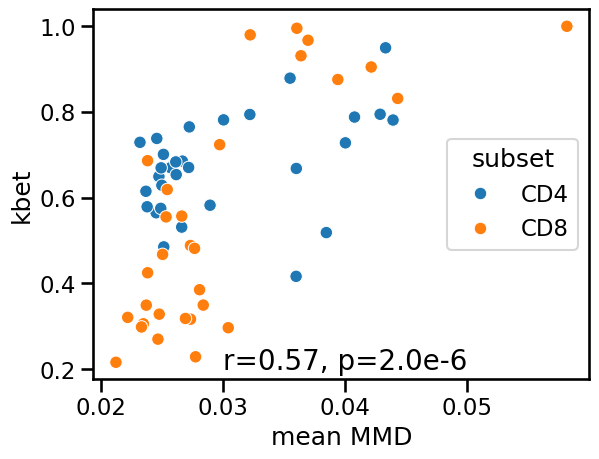

In [66]:
sel_res = res[res["metric"]=="mean_mmd"]
sel_res = sel_res[sel_res["setting"]=="CAROT"]
spearman = round(spearmanr(sel_res[["score", "kbet"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "kbet"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="kbet", hue="subset")
# plt.axline((0.5, 0.5), slope=-1)
plt.xlabel("mean MMD")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.03, 0.2), fontsize=20)
plt.savefig(f"{base_fig_dir}monge_kbet_mmd.pdf", dpi=300, bbox_inches="tight")

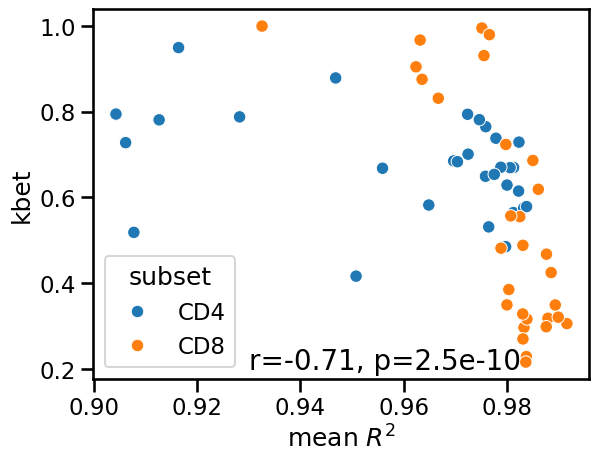

In [67]:
sel_res = res[res["metric"]=="mean_r2"]
sel_res = sel_res[sel_res["setting"]=="CAROT"]
spearman = round(spearmanr(sel_res[["score", "kbet"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "kbet"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="kbet", hue="subset")
# plt.axline((0.5, 0.5), slope=1)
plt.xlabel("mean $R^2$")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.93, 0.2), fontsize=20)
plt.savefig(f"{base_fig_dir}monge_kbet_r2.pdf", dpi=300, bbox_inches="tight")

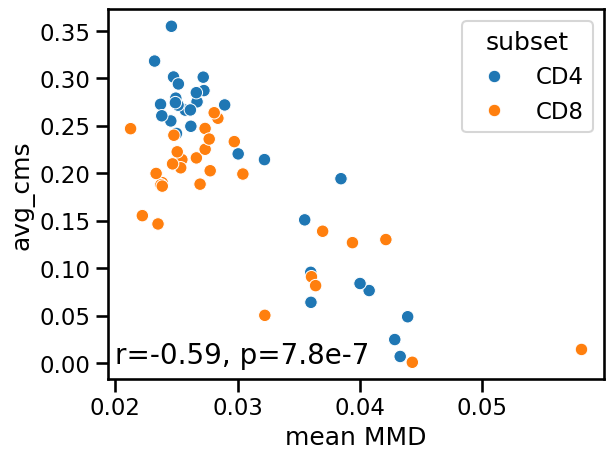

In [21]:
sel_res = res[res["metric"]=="mean_mmd"]
sel_res = sel_res[sel_res["setting"]=="CAROT"]
spearman = round(spearmanr(sel_res[["score", "avg_cms"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "avg_cms"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="avg_cms", hue="subset")
# plt.axline((0.5, 0.5), slope=-1)
plt.xlabel("mean MMD")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.02, 0), fontsize=20)
plt.savefig(f"{base_fig_dir}monge_cms_mmd.pdf", dpi=300, bbox_inches="tight")

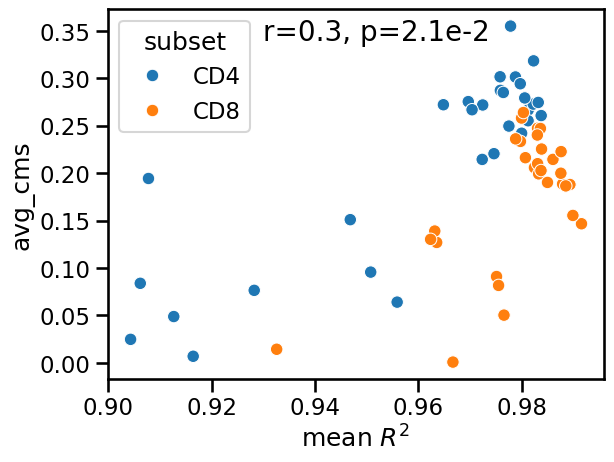

In [22]:
sel_res = res[res["metric"]=="mean_r2"]
sel_res = sel_res[sel_res["setting"]=="CAROT"]
spearman = round(spearmanr(sel_res[["score", "avg_cms"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "avg_cms"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="avg_cms", hue="subset")
plt.xlabel("mean $R^2$")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.93, 0.34), fontsize=20)
plt.savefig(f"{base_fig_dir}monge_cms_r2.pdf", dpi=300, bbox_inches="tight")

In [23]:
# stats.to_csv("/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/mean_stats.csv")
# expression.to_csv("/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/expression.csv")
# meta.to_csv("/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/meta.csv")
# umap_data.to_csv("/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/umap_data.csv")




In [24]:
# meta

# CMonge - ID&OOD

## Scores

In [25]:
exp_order = ["conCAROT", "identity"] + ["within condition"]*32

all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    for embedding in ["esm_XL_tail_dim"]:
        with open(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/{subset}_{embedding}_FuncScore/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        print(subset, embedding, len(logs["experiments"]))
        
        for i in range(len(logs["experiments"])):
            eval_setting = exp_order[i]
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["embedding"] = embedding
                res["eval_car"] = condition
                res["eval_setting"] = eval_setting
                res["subset"] = subset
                all_mean_metrics.append(res)

CD4 esm_XL_tail_dim 18
CD8 esm_XL_tail_dim 16


In [26]:
res = pd.concat(all_mean_metrics).reset_index(drop=True)
res = res[~res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
res.loc[res["embedding"]=="esm_XL_tail_dim", "embedding"] = "ESM XL"
res

,metric,score,embedding,eval_car,eval_setting,subset
0,mean_wasserstein,5.533756,ESM XL,CD28-IL15RA-z,conCAROT,CD4
1,mean_mmd,0.026047,ESM XL,CD28-IL15RA-z,conCAROT,CD4
2,mean_sinkhorn div,5.047623,ESM XL,CD28-IL15RA-z,conCAROT,CD4
3,mean_monge_gap,11.387654,ESM XL,CD28-IL15RA-z,conCAROT,CD4
4,mean_drug_signature,0.756655,ESM XL,CD28-IL15RA-z,conCAROT,CD4
...,...,...,...,...,...,...
535,mean_mmd,0.014717,ESM XL,41BB-41BB-z,within condition,CD8
536,mean_sinkhorn div,5.485166,ESM XL,41BB-41BB-z,within condition,CD8
537,mean_monge_gap,12.362149,ESM XL,41BB-41BB-z,within condition,CD8
538,mean_drug_signature,0.886871,ESM XL,41BB-41BB-z,within condition,CD8


In [27]:
# CMonge OOD results
logger_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"

all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["identity", "cmonge", "within condition"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_small_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                ood_res = pd.Series(results["mean_statistics"])
                ood_res = ood_res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                ood_res["eval_car"] = condition
                ood_res["eval_setting"] = "conCAROT-OOD" if setting=="cmonge" else setting
                ood_res["subset"] = subset
                all_mean_metrics.append(ood_res)

In [28]:
ood_res = pd.concat(all_mean_metrics)

In [29]:
res = pd.concat([res, ood_res])

In [30]:
res["eval_setting"].unique()

array(['conCAROT', 'identity', 'within condition', 'conCAROT-OOD'],
      dtype=object)

## Source, target, transport

In [31]:
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path =   "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"

In [32]:
all_kbet = []
expression_list = []
umap_list = []
meta_list = []
subset_car = []
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]
    umapper = umap.UMAP(random_state=1234)
    Y1 = umapper.fit_transform(sel_adata.X)
    sel_adata.obsm["X_umap"] = Y1
    
    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = f"/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}_sel_cars.txt"
    config.model.embedding.model_dir = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/embedding/"

    with open(config.data.drugs_path) as f:
        train_cars = f.readlines()
    train_cars = [c[:-1] for c in train_cars]
    print(sorted(train_cars))

    for car in cars:
        config.condition.split = [0.8,0.2,0]
        config.data.split = [0.8,0.2,0]
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        if car not in train_cars:
            print("Changing split")
            config.condition.split = [0,1,0]
            config.data.split = [0,1,0]
        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]
        
        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
        # all_meta = all_expr[["dtype", "condition"]]
        all_meta["dtype"] = ["transport" if d=="trans" else d for d in all_meta["dtype"]]
        all_expr = all_expr.iloc[:,:82]

        if car in train_cars:
            all_meta["split"] = "ID"
        else:
            all_meta["split"] = "OOD"

        Y2 = umapper.transform(all_expr)

        adata = ad.AnnData(all_expr)
        adata.obs = all_meta.reset_index(drop=True)
        adata.obsm["UMAP"] = Y2
        target_transport_adata = adata[adata.obs["dtype"].isin(['target', 'transport'])]
        kbet = scib.metrics.kBET(target_transport_adata, batch_key="dtype", label_key="Time", type_="embed", embed="UMAP")
        expression_list.append(all_expr)
        meta_list.append(all_meta)
        umap_list.append(pd.DataFrame(Y2, columns=["UMAP1", "UMAP2"]))
        subset_car.append(f"{subset}_{car}")
        
        all_kbet.append(kbet)

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_12070/1489126123.py:14: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


['41BB-41BB-z', '41BB-CD28-z', '41BB-CD40-z', '41BB-IL15RA-z', '41BB-NA-z', 'CD28-CD28-z', 'CD28-CD40-z', 'CD28-IL15RA-z', 'CD28-NA-z', 'CD40-IL15RA-z', 'CD40-NA-z', 'IL15RA-41BB-z', 'IL15RA-CD28-z', 'IL15RA-CD40-z', 'IL15RA-IL15RA-z', 'IL15RA-NA-z']
41BB-41BB-z


2025-08-20 17:42:25.917 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-20 17:42:26.128 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:26.134 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-08-20 17:42:26.134 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:26.134 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:26.135 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:26.834 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CD28-z


2025-08-20 17:42:30.073 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-20 17:42:30.287 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:30.293 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-08-20 17:42:30.293 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:30.293 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:30.293 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:30.315 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CD40-z


2025-08-20 17:42:31.632 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-20 17:42:31.847 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:31.853 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-08-20 17:42:31.853 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:31.853 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:31.853 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:31.876 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CTLA4-z
Changing split


2025-08-20 17:42:33.225 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-20 17:42:33.497 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:33.502 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (311,), test: (0,).
2025-08-20 17:42:33.502 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:42:33.502 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:33.503 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:33.525 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(311, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-IL15RA-z


2025-08-20 17:42:35.895 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-20 17:42:36.181 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:36.187 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-08-20 17:42:36.187 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:36.187 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:36.187 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:36.209 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-NA-z


2025-08-20 17:42:37.728 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-20 17:42:38.016 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:38.022 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-08-20 17:42:38.022 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:38.022 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:38.022 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:38.044 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-41BB-z
Changing split


2025-08-20 17:42:39.289 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-20 17:42:39.571 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:39.576 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (215,), test: (0,).
2025-08-20 17:42:39.576 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:42:39.577 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:39.577 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:39.600 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(215, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in t

CD28-CD28-z


2025-08-20 17:42:41.855 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-20 17:42:42.208 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:42.217 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-08-20 17:42:42.217 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:42.217 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:42.217 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:42.240 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CD40-z


2025-08-20 17:42:43.896 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-20 17:42:44.249 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:44.255 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-08-20 17:42:44.255 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:44.256 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:44.256 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:44.278 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CTLA4-z
Changing split


2025-08-20 17:42:45.561 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-20 17:42:45.916 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:45.923 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (268,), test: (0,).
2025-08-20 17:42:45.924 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:42:45.924 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:45.924 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:45.950 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(268, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-IL15RA-z


2025-08-20 17:42:48.530 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-20 17:42:48.986 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:48.993 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-08-20 17:42:48.993 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:48.993 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:48.994 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:49.019 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-NA-z


2025-08-20 17:42:50.636 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-20 17:42:51.204 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:51.213 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-08-20 17:42:51.214 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:42:51.214 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:51.214 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:51.239 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'f

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-41BB-z
Changing split


2025-08-20 17:42:52.756 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-20 17:42:53.263 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:53.269 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (696,), test: (0,).
2025-08-20 17:42:53.269 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:42:53.270 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:53.270 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:53.295 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(696, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-CD28-z
Changing split


2025-08-20 17:42:57.172 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-20 17:42:57.652 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:42:57.661 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (738,), test: (0,).
2025-08-20 17:42:57.662 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:42:57.662 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:42:57.662 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:42:57.698 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(738, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-CD40-z
Changing split


2025-08-20 17:43:01.715 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-20 17:43:02.176 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:02.185 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (678,), test: (0,).
2025-08-20 17:43:02.186 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:02.186 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:02.186 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:02.221 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(678, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-CTLA4-z
Changing split


2025-08-20 17:43:06.022 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-20 17:43:06.502 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:06.512 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (324,), test: (0,).
2025-08-20 17:43:06.513 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:06.513 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:06.513 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:06.547 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(324, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-IL15RA-z


2025-08-20 17:43:09.110 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-20 17:43:09.691 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:09.701 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-08-20 17:43:09.702 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:09.702 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:09.702 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:09.739 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD40-NA-z


2025-08-20 17:43:11.319 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-20 17:43:11.858 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:11.868 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-08-20 17:43:11.869 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:11.870 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:11.870 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:11.901 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'fo

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-41BB-z
Changing split


2025-08-20 17:43:13.427 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-20 17:43:14.018 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:14.026 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (236,), test: (0,).
2025-08-20 17:43:14.027 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:14.027 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:14.027 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:14.061 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(236, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CD28-z
Changing split


2025-08-20 17:43:16.551 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-20 17:43:17.057 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:17.067 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (565,), test: (0,).
2025-08-20 17:43:17.067 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:17.067 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:17.068 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:17.105 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(565, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CD40-z
Changing split


2025-08-20 17:43:20.692 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-20 17:43:21.162 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:21.172 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (203,), test: (0,).
2025-08-20 17:43:21.172 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:21.173 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:21.173 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:21.203 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(203, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CTLA4-z
Changing split


2025-08-20 17:43:23.544 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-20 17:43:24.094 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:24.104 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (278,), test: (0,).
2025-08-20 17:43:24.104 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:24.104 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:24.104 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:24.137 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(278, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-IL15RA-z
Changing split


2025-08-20 17:43:26.570 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-20 17:43:27.100 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:27.110 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (190,), test: (0,).
2025-08-20 17:43:27.110 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:27.110 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:27.110 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:27.134 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(190, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-NA-z
Changing split


2025-08-20 17:43:29.410 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-20 17:43:29.973 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:29.983 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (214,), test: (0,).
2025-08-20 17:43:29.983 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:29.983 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:29.984 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:30.015 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(214, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-41BB-z


2025-08-20 17:43:32.336 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-20 17:43:32.842 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:32.854 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-08-20 17:43:32.854 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:32.855 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:32.855 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:32.881 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CD28-z


2025-08-20 17:43:34.398 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-20 17:43:34.923 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:34.931 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-08-20 17:43:34.931 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:34.931 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:34.931 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:34.956 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CD40-z


2025-08-20 17:43:36.520 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-20 17:43:37.048 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:37.055 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-08-20 17:43:37.055 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:37.055 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:37.055 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:37.080 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CTLA4-z
Changing split


2025-08-20 17:43:38.614 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-20 17:43:39.146 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:39.154 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (456,), test: (0,).
2025-08-20 17:43:39.155 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (759,), test: (0,).
2025-08-20 17:43:39.155 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:39.155 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:39.182 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(456, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-IL15RA-z


2025-08-20 17:43:42.285 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-20 17:43:42.817 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:42.825 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-08-20 17:43:42.826 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:42.826 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:42.826 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:42.848 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-NA-z


2025-08-20 17:43:44.375 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-20 17:43:44.911 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:43:44.919 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-08-20 17:43:44.919 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-08-20 17:43:44.919 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:43:44.919 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:43:44.953 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 

Evaluating on validation set
(151, 5120)
0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_12070/1489126123.py:14: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  sel_adata.obsm["X_umap"] = Y1


['41BB-41BB-z', '41BB-IL15RA-z', '41BB-NA-z', 'CD28-CD28-z', 'CD28-IL15RA-z', 'CD28-NA-z', 'CD40-CD28-z', 'CD40-CD40-z', 'CD40-NA-z', 'IL15RA-41BB-z', 'IL15RA-CD28-z', 'IL15RA-CD40-z', 'IL15RA-CTLA4-z', 'IL15RA-NA-z']
41BB-41BB-z


2025-08-20 17:44:06.501 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-08-20 17:44:06.803 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:06.812 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-20 17:44:06.812 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:06.813 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:06.813 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:06.845 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


41BB-CD28-z
Changing split


2025-08-20 17:44:10.506 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-08-20 17:44:11.000 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:11.007 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (727,), test: (0,).
2025-08-20 17:44:11.008 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:11.008 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:11.008 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:11.039 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(727, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


41BB-CD40-z
Changing split


2025-08-20 17:44:17.120 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-08-20 17:44:17.366 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:17.372 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (472,), test: (0,).
2025-08-20 17:44:17.372 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:17.372 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:17.372 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:17.397 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(472, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


41BB-CTLA4-z
Changing split


2025-08-20 17:44:20.078 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-08-20 17:44:20.287 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:20.292 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (265,), test: (0,).
2025-08-20 17:44:20.293 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:20.293 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:20.294 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:20.316 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(265, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


41BB-IL15RA-z


2025-08-20 17:44:22.390 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-08-20 17:44:22.590 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:22.596 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-08-20 17:44:22.596 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:22.596 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:22.597 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:22.620 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(211, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
41BB-NA-z


2025-08-20 17:44:24.443 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-08-20 17:44:24.645 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:24.650 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-08-20 17:44:24.650 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:24.651 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:24.651 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:24.672 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(197, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD28-41BB-z
Changing split


2025-08-20 17:44:26.439 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-08-20 17:44:26.653 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:26.658 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (258,), test: (0,).
2025-08-20 17:44:26.659 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:26.659 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:26.659 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:26.682 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(258, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-CD28-z


2025-08-20 17:44:28.758 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-08-20 17:44:28.994 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:28.999 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-08-20 17:44:29.000 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:29.000 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:29.000 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:29.023 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(168, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD28-CD40-z
Changing split


2025-08-20 17:44:30.794 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-08-20 17:44:31.075 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:31.081 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (658,), test: (0,).
2025-08-20 17:44:31.082 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:31.082 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:31.082 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:31.109 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(658, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
CD28-CTLA4-z
Changing split


2025-08-20 17:44:34.456 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-08-20 17:44:34.723 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:34.729 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (438,), test: (0,).
2025-08-20 17:44:34.729 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:34.729 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:34.729 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:34.752 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(438, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CD28-IL15RA-z


2025-08-20 17:44:37.750 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-08-20 17:44:38.034 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:38.043 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-08-20 17:44:38.044 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:38.044 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:38.044 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:38.077 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(179, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD28-NA-z


2025-08-20 17:44:40.159 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-08-20 17:44:40.461 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:40.470 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-08-20 17:44:40.471 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:40.471 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:40.471 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:40.501 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(220, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
CD40-41BB-z
Changing split


2025-08-20 17:44:42.742 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-08-20 17:44:43.022 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:43.029 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (609,), test: (0,).
2025-08-20 17:44:43.030 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:43.030 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:43.030 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:43.058 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(609, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD40-CD28-z


2025-08-20 17:44:46.684 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-08-20 17:44:47.144 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:47.151 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-08-20 17:44:47.151 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:47.151 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:47.151 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:47.198 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(193, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CD40-CD40-z


2025-08-20 17:44:49.245 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-08-20 17:44:49.740 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:49.747 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-08-20 17:44:49.747 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:44:49.747 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:49.747 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:49.772 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(272, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
CD40-CTLA4-z
Changing split


2025-08-20 17:44:52.030 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-08-20 17:44:52.472 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:52.481 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (699,), test: (0,).
2025-08-20 17:44:52.481 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:52.481 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:52.481 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:52.508 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(699, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
CD40-IL15RA-z
Changing split


2025-08-20 17:44:56.518 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-08-20 17:44:56.983 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:44:56.991 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (691,), test: (0,).
2025-08-20 17:44:56.991 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:44:56.992 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:44:56.992 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:44:57.020 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(691, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
CD40-NA-z


2025-08-20 17:45:01.163 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-08-20 17:45:01.710 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:01.726 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-08-20 17:45:01.726 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:45:01.728 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:01.729 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:01.772 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(251, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
CTLA4-41BB-z
Changing split


2025-08-20 17:45:03.836 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-08-20 17:45:04.319 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:04.330 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (172,), test: (0,).
2025-08-20 17:45:04.330 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:04.330 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:04.331 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:04.359 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(172, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CTLA4-CD28-z
Changing split


2025-08-20 17:45:06.404 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-08-20 17:45:06.983 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:06.993 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (253,), test: (0,).
2025-08-20 17:45:06.994 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:06.994 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:06.994 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:07.032 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(253, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
CTLA4-CD40-z
Changing split


2025-08-20 17:45:09.566 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-08-20 17:45:10.026 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:10.037 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (276,), test: (0,).
2025-08-20 17:45:10.038 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:10.038 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:10.038 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:10.072 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(276, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


CTLA4-CTLA4-z
Changing split


2025-08-20 17:45:12.575 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-08-20 17:45:13.064 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:13.073 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (122,), test: (0,).
2025-08-20 17:45:13.073 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:13.073 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:13.074 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:13.122 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(122, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 5


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CTLA4-IL15RA-z
Changing split


2025-08-20 17:45:14.890 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-08-20 17:45:15.339 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:15.361 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (234,), test: (0,).
2025-08-20 17:45:15.362 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:15.363 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:15.363 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:15.403 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(234, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


CTLA4-NA-z
Changing split


2025-08-20 17:45:19.252 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-08-20 17:45:19.477 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:19.483 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (252,), test: (0,).
2025-08-20 17:45:19.484 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:19.484 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:19.484 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:19.518 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(252, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-41BB-z


2025-08-20 17:45:21.602 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-08-20 17:45:21.814 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:21.820 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-08-20 17:45:21.820 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:45:21.820 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:21.821 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:21.847 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(241, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-CD28-z


2025-08-20 17:45:23.715 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-08-20 17:45:23.927 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:23.934 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-08-20 17:45:23.934 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:45:23.934 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:23.935 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:23.960 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning

Evaluating on validation set
(157, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
IL15RA-CD40-z


2025-08-20 17:45:25.347 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-08-20 17:45:25.548 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:25.554 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-08-20 17:45:25.554 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:45:25.555 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:25.555 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:25.576 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(284, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


IL15RA-CTLA4-z


2025-08-20 17:45:27.916 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-08-20 17:45:28.131 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:28.138 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-08-20 17:45:28.139 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:45:28.140 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:28.140 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:28.165 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarnin

Evaluating on validation set
(234, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata_tmp.obs.groupby(label_key).agg(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with acti

0 labels consist of a single batch or is too small. Skip.


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-IL15RA-z
Changing split


2025-08-20 17:45:29.259 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-08-20 17:45:29.469 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:29.475 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (0,), valid: (612,), test: (0,).
2025-08-20 17:45:29.475 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (0,), valid: (1423,), test: (0,).
2025-08-20 17:45:29.475 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:29.475 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:29.499 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(612, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


IL15RA-NA-z


2025-08-20 17:45:33.082 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-08-20 17:45:33.369 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-08-20 17:45:33.376 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-08-20 17:45:33.376 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-08-20 17:45:33.376 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-08-20 17:45:33.377 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-08-20 17:45:33.399 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(231, 5120)


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

0 labels consist of a single batch or is too small. Skip.
Adding diffusion to step 4
Adding diffusion to step 4


/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


In [33]:
kbets = pd.DataFrame(all_kbet, columns=["kbet"])
kbets["subset"] = ["CD4"] * 30 + ["CD8"]*30
kbets["eval_car"] = cars[:-2] *2

In [34]:
# expression = pd.concat(expression_list, keys=subset_car, names=["subset_CAR", ""]).reset_index("", drop=True).reset_index("subset_CAR", drop=False)
# umap_data = pd.concat(umap_list, keys=subset_car, names=["subset_CAR", ""]).reset_index("", drop=True).reset_index("subset_CAR", drop=False)
# meta = pd.concat(meta_list, keys=subset_car, names=["subset_CAR", ""]).reset_index("", drop=True).reset_index("subset_CAR", drop=False)
# umap_data

In [35]:
# res.to_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/mean_stats.csv")
# expression.to_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/expression.csv")
# meta.to_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/meta.csv")
# umap_data.to_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/umap_data.csv")




In [36]:
cms = pd.read_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/cms_scores.csv")
cms[["subset", "eval_car"]] = [c.split("_") for c in cms["subset_CAR"]]
cms = cms.drop("subset_CAR", axis=1)

In [37]:
res = pd.merge(res, cms, on=["subset", "eval_car"])
res = pd.merge(res, kbets, on=["subset", "eval_car"])
res

,metric,score,embedding,eval_car,eval_setting,subset,avg_cms,kbet
0,mean_wasserstein,5.533756,ESM XL,CD28-IL15RA-z,conCAROT,CD4,0.136062,0.617600
1,mean_mmd,0.026047,ESM XL,CD28-IL15RA-z,conCAROT,CD4,0.136062,0.617600
2,mean_sinkhorn div,5.047623,ESM XL,CD28-IL15RA-z,conCAROT,CD4,0.136062,0.617600
3,mean_monge_gap,11.387654,ESM XL,CD28-IL15RA-z,conCAROT,CD4,0.136062,0.617600
4,mean_drug_signature,0.756655,ESM XL,CD28-IL15RA-z,conCAROT,CD4,0.136062,0.617600
...,...,...,...,...,...,...,...,...
1063,mean_mmd,0.058884,NaN,CTLA4-NA-z,within condition,CD8,0.123562,0.438004
1064,mean_sinkhorn div,6.424349,NaN,CTLA4-NA-z,within condition,CD8,0.123562,0.438004
1065,mean_monge_gap,7.827336,NaN,CTLA4-NA-z,within condition,CD8,0.123562,0.438004
1066,mean_drug_signature,1.707112,NaN,CTLA4-NA-z,within condition,CD8,0.123562,0.438004


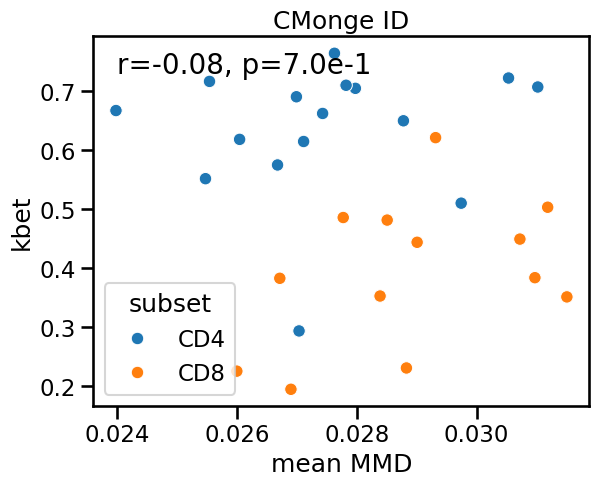

In [52]:
sel_res = res[res["metric"]=="mean_mmd"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT"]
spearman = round(spearmanr(sel_res[["score", "kbet"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "kbet"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="kbet", hue="subset")
plt.title("CMonge ID")
plt.xlabel("mean MMD")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.024, 0.73), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_kbet_mmd.pdf", dpi=300, bbox_inches="tight")

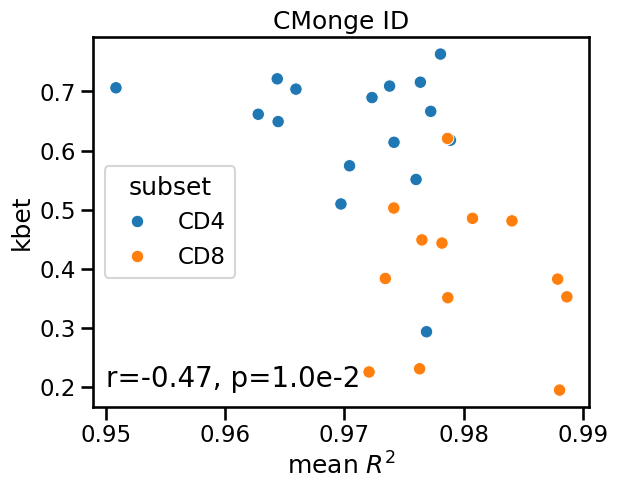

In [39]:
sel_res = res[res["metric"]=="mean_r2"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT"]
spearman = round(spearmanr(sel_res[["score", "kbet"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "kbet"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="kbet", hue="subset")
plt.title("CMonge ID")
plt.xlabel("mean $R^2$")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.95, 0.2), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_kbet_r2.pdf", dpi=300, bbox_inches="tight")

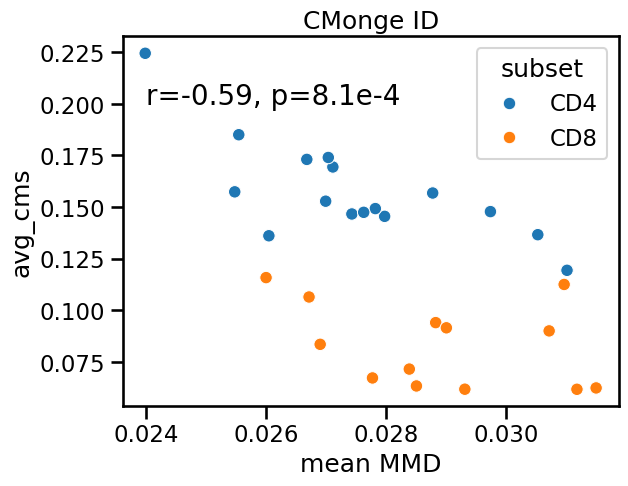

In [40]:
sel_res = res[res["metric"]=="mean_mmd"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT"]
spearman = round(spearmanr(sel_res[["score", "avg_cms"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "avg_cms"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="avg_cms", hue="subset")
plt.title("CMonge ID")
plt.xlabel("mean MMD")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.024, 0.2), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_cms_mmd.pdf", dpi=300, bbox_inches="tight")

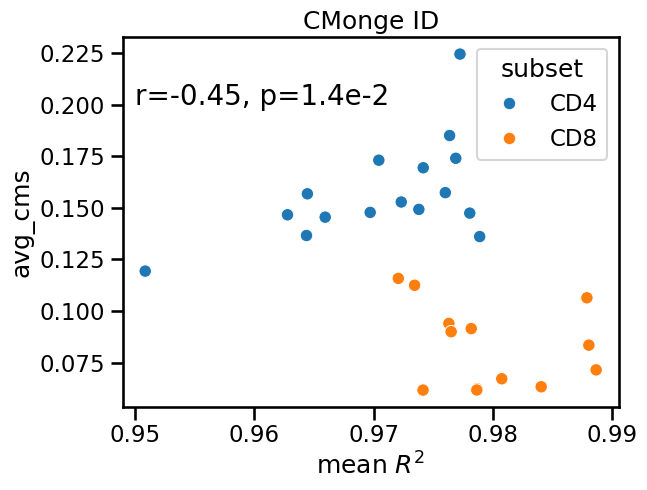

In [41]:
sel_res = res[res["metric"]=="mean_r2"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT"]
spearman = round(spearmanr(sel_res[["score", "avg_cms"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "avg_cms"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="avg_cms", hue="subset")
plt.title("CMonge ID")
plt.xlabel("mean $R^2$")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.95, 0.2), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_cms_r2.pdf", dpi=300, bbox_inches="tight")

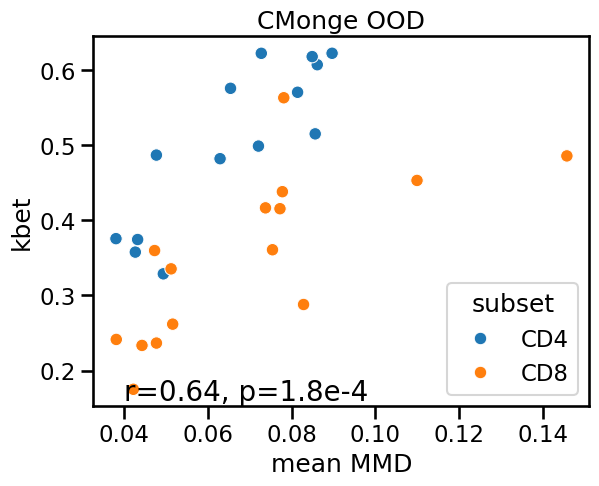

In [42]:
sel_res = res[res["metric"]=="mean_mmd"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT-OOD"]
spearman = round(spearmanr(sel_res[["score", "kbet"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "kbet"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="kbet", hue="subset")
plt.title("CMonge OOD")
plt.xlabel("mean MMD")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.04, 0.16), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_OOD_kbet_mmd.pdf", dpi=300, bbox_inches="tight")

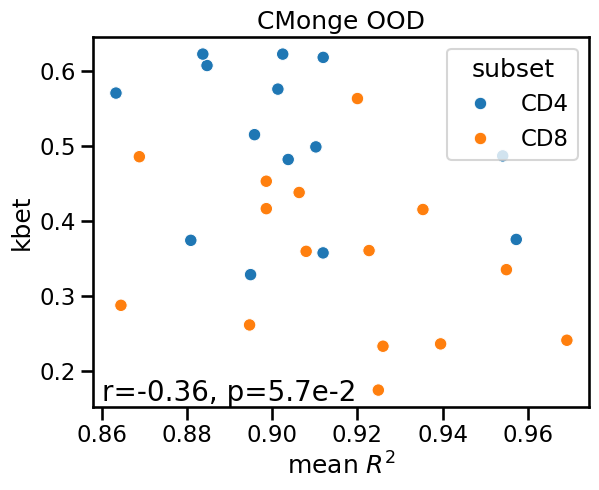

In [43]:
sel_res = res[res["metric"]=="mean_r2"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT-OOD"]
spearman = round(spearmanr(sel_res[["score", "kbet"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "kbet"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="kbet", hue="subset")
plt.title("CMonge OOD")
plt.xlabel("mean $R^2$")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.86, 0.16), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_OOD_kbet_r2.pdf", dpi=300, bbox_inches="tight")

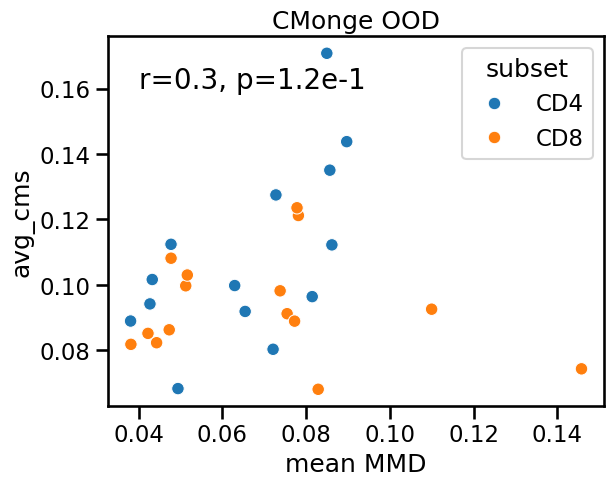

In [44]:
sel_res = res[res["metric"]=="mean_mmd"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT-OOD"]
spearman = round(spearmanr(sel_res[["score", "avg_cms"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "avg_cms"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="avg_cms", hue="subset")
plt.title("CMonge OOD")
plt.xlabel("mean MMD")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.04, 0.16), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_OOD_cms_mmd.pdf", dpi=300, bbox_inches="tight")

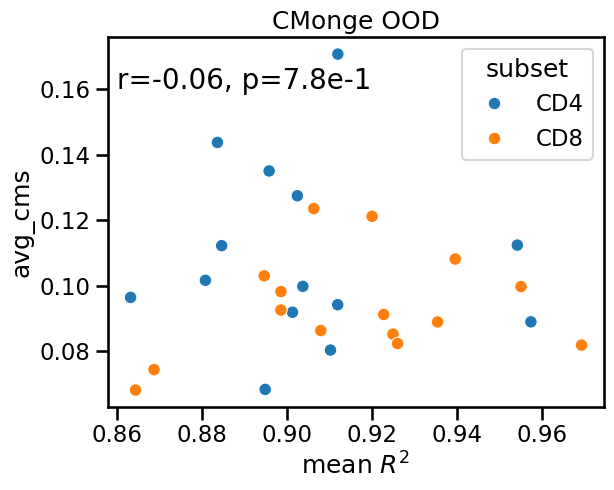

In [45]:
sel_res = res[res["metric"]=="mean_r2"]
sel_res = sel_res[sel_res["eval_setting"]=="conCAROT-OOD"]
spearman = round(spearmanr(sel_res[["score", "avg_cms"]]).statistic, 2)
pval = Decimal(spearmanr(sel_res[["score", "avg_cms"]]).pvalue)
pval = '{:.1e}'.format(pval)
sns.scatterplot(data=sel_res, x="score", y="avg_cms", hue="subset")
plt.title("CMonge OOD")
plt.xlabel("mean $R^2$")
plt.annotate(f"r={spearman}, p={pval}", xy=(0.86, 0.16), fontsize=20)
plt.savefig(f"{base_fig_dir}cmonge_OOD_cms_r2.pdf", dpi=300, bbox_inches="tight")

In [46]:
sel_res

,metric,score,embedding,eval_car,eval_setting,subset,avg_cms,kbet
611,mean_r2,0.901292,NaN,41BB-CTLA4-z,conCAROT-OOD,CD4,0.091853,0.575531
617,mean_r2,0.884637,NaN,CD28-41BB-z,conCAROT-OOD,CD4,0.112213,0.606933
623,mean_r2,0.902431,NaN,CD28-CTLA4-z,conCAROT-OOD,CD4,0.127489,0.622085
629,mean_r2,0.911916,NaN,CD40-41BB-z,conCAROT-OOD,CD4,0.094157,0.357618
635,mean_r2,0.957323,NaN,CD40-CD28-z,conCAROT-OOD,CD4,0.088918,0.375537
641,mean_r2,0.880820,NaN,CD40-CD40-z,conCAROT-OOD,CD4,0.101620,0.374358
647,mean_r2,0.903716,NaN,CD40-CTLA4-z,conCAROT-OOD,CD4,0.099773,0.481904
653,mean_r2,0.863234,NaN,CTLA4-41BB-z,conCAROT-OOD,CD4,0.096386,0.570267
659,mean_r2,0.894878,NaN,CTLA4-CD28-z,conCAROT-OOD,CD4,0.068260,0.328721
665,mean_r2,0.895800,NaN,CTLA4-CD40-z,conCAROT-OOD,CD4,0.135061,0.514933
